In [295]:
import numpy as np
import numpy.ma as ma
import os
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
import subprocess
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
import os
import glob
!pip install astroquery

In [296]:
import subprocess

def run_command(command, use_wsl=True):
    """
    Function to convert Windows paths to WSL paths and execute a command in WSL
    """
    def to_wsl_path(win_path):
        """Convert Windows path like C:\\path\\to\\file to /mnt/c/path/to/file"""
        if ":" in win_path:
            drive = win_path[0].lower()  # Get drive letter (c, d, etc.)
            path_part = win_path[3:].replace("\\", "/")  # Remove C:\ and convert
            return f"/mnt/{drive}/{path_part}"
        return win_path.replace("\\", "/")

    if use_wsl:
        command = [
            to_wsl_path(arg) if "\\" in arg else arg for arg in command
        ]
        command.insert(0, "wsl")

    print("Executing command:")
    print(" ".join(command))

    try:
        result = subprocess.run(command, check=True, capture_output=True, text=True)
        print("Command completed successfully")
        if result.stdout:
            print("Output:", result.stdout[:500])
    except FileNotFoundError as err:
        print(f"File not found: {err}")

In [297]:
imageName = "C:\\Users\\norna\\OneDrive\\Desktop\\kcap\\data\\20251017142-734-RA.wcs.proc.fits"
f = fits.open(imageName)
data = f[0].data  # This is the image array
header = f[0].header
filt = header["FILTER"]
axis1 = header["NAXIS1"]
axis2 = header["NAXIS2"]

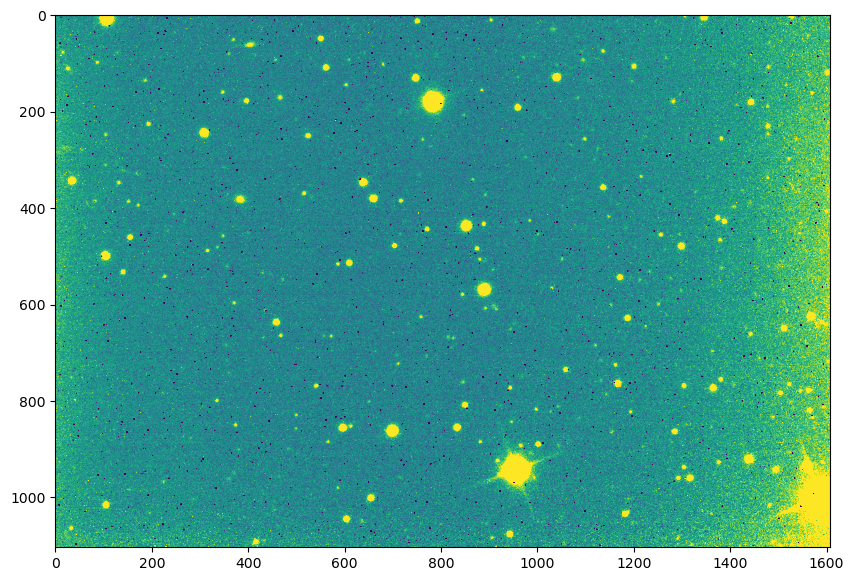

In [298]:
mean, median, sigma = sigma_clipped_stats(data)

# plot the image with some reasonable scale
plt.figure(figsize=(10, 10))
plt.imshow(data, vmin=median - 3 * sigma, vmax=median + 3 * sigma)
plt.show()

In [299]:
# strong the image WCS into an object
w = WCS(header)

# Get the RA and Dec of the center of the image
[raImage, decImage] = w.all_pix2world(data.shape[0] / 2, data.shape[1] / 2, 1)

# Set the box size to search for catalog stars
boxsize = 10  # arcminutes

# Magnitude cut-offs of sources to be cross-matched against
maxmag = 19

In [300]:
from astroquery.vizier import Vizier
# Vizier.VIZIER_SERVER = 'vizier.ast.cam.ac.uk'

catNum = "II/349"  # This is the catalog number of PS1 in Vizier
print(
    "\nQuerying Vizier %s around RA %.4f, Dec %.4f with a radius of %.4f arcmin"
    % (catNum, raImage, decImage, boxsize)
)

try:
    # You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    v = Vizier(
        columns=["*"],
        column_filters={
            f"{filt}mag": f"< {maxmag:.2f}",
            "Nd": ">6",
            f"e_{filt}mag": "< 0.05",
        },
        row_limit=-1,
        timeout=120,
    )
    Q = v.query_region(
        SkyCoord(ra=raImage, dec=decImage, unit=(u.deg, u.deg)),
        radius=str(boxsize) + "m",
        catalog=catNum,
        cache=False,
    )
    # print(Q[0])
# query vizier around (ra, dec) with a radius of boxsize
except:
    print("I cannnot reach the Vizier database. Is the internet working?")


Querying Vizier II/349 around RA 260.2188, Dec 58.0725 with a radius of 10.0000 arcmin


In [301]:
# Convert the world coordinates of these stars to image coordinates
ps1_imCoords = w.all_world2pix(Q[0]["RAJ2000"], Q[0]["DEJ2000"], 2)

# Another round of filtering where we reject sources close to the edges
good_cat_stars = Q[0][
    np.where(
        (ps1_imCoords[0] > 10)
        & (ps1_imCoords[0] < (axis1 - 70))
        & (ps1_imCoords[1] > 10)
        & (ps1_imCoords[1] < (axis2 - 70))
    )
]
print(good_cat_stars)

   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag  yFlags 
     deg           deg                         ...   mag     mag           
------------- ------------- ------------------ ... ------- ------- --------
260.248947590  57.951598430 177542602488822636 ... 18.1207  0.0206   115000
260.275949520  57.945341940 177532602758825125 ... 18.6702  0.0416   115000
260.255319400  57.962037240 177552602552485172 ... 18.1282  0.0240   115000
260.278650400  57.968920980 177562602785963459 ... 17.9971  0.0298 16892216
260.252104080  57.950902340 177542602520261814 ... 17.4595  0.0273   115000
260.264780540  57.952271110 177542602647093449 ... 16.2622  0.0069   115000
260.299712650  57.974078770 177562602996359633 ... 16.8202  0.0082   115000
260.308915770  57.991688050 177592603088590765 ... 15.0707  0.0078   115000
260.311436540  57.979274380 177572603113385896 ... 17.2518  0.0105   115000
          ...           ...                ... ...     ...     ...      ...
260.34834381

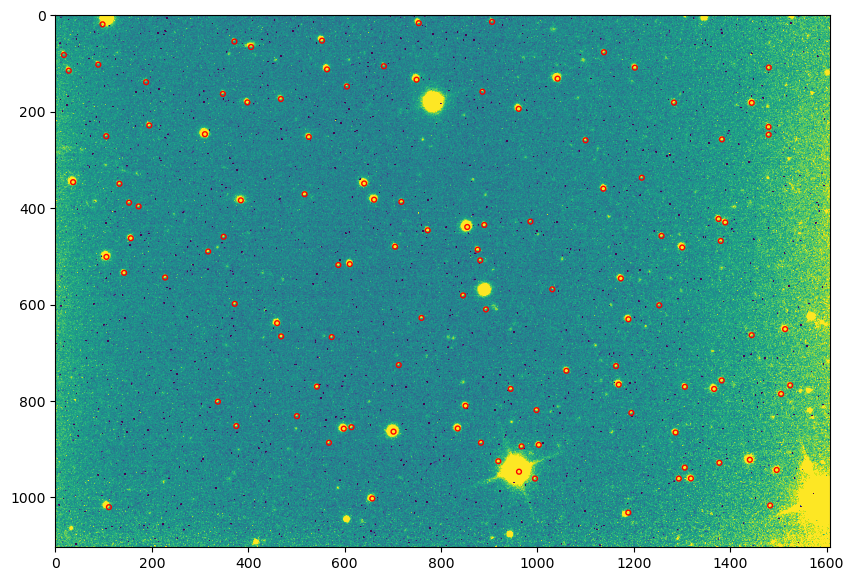

In [302]:
ps1_imCoords = w.all_world2pix(good_cat_stars["RAJ2000"], good_cat_stars["DEJ2000"], 1)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(data, vmin=median - 3 * sigma, vmax=median + 3 * sigma)
circles = [
    plt.Circle(
        (ps1_imCoords[0][i], ps1_imCoords[1][i]),
        radius=5,
        edgecolor="r",
        facecolor="None",
    )
    for i in range(len(ps1_imCoords[0]))
]
for c in circles:
    ax.add_artist(c)

plt.show()

In [303]:
# Define paths
configFile = r"C:\Users\norna\OneDrive\Desktop\kcap\config\astrom.sex"
paramName = r"C:\Users\norna\OneDrive\Desktop\kcap\config\astrom.param"
catalogName = imageName + ".cat"

# Command to run SExtractor
command = [
    "/usr/local/bin/sex",
    imageName,
    "-c", configFile,
    "-CATALOG_NAME", catalogName,
    "-PARAMETERS_NAME", paramName,
    "-VERBOSE_TYPE", "NORMAL",
]

run_command(command)

Executing command:
wsl /usr/local/bin/sex /mnt/c/Users/norna/OneDrive/Desktop/kcap/data/20251017142-734-RA.wcs.proc.fits -c /mnt/c/Users/norna/OneDrive/Desktop/kcap/config/astrom.sex -CATALOG_NAME /mnt/c/Users/norna/OneDrive/Desktop/kcap/data/20251017142-734-RA.wcs.proc.fits.cat -PARAMETERS_NAME /mnt/c/Users/norna/OneDrive/Desktop/kcap/config/astrom.param -VERBOSE_TYPE NORMAL
Command completed successfully


In [304]:
def get_table_from_ldac(filename, frame=1):
    """
    Load an astropy table from a fits_ldac by frame (Since the ldac format has column
    info for odd tables, giving it twce as many tables as a regular fits BinTableHDU,
    match the frame of a table to its corresponding frame in the ldac file).

    Parameters
    ----------
    filename: str
        Name of the file to open
    frame: int
        Number of the frame in a regular fits file
    """
    from astropy.table import Table

    if frame > 0:
        frame = frame * 2
    tbl = Table.read(filename, hdu=frame)
    return tbl

In [305]:
# This is a python wrapper for reading LDAC files produced by SExtractor
sourceTable = get_table_from_ldac(catalogName)
# Let's look at the contents of the table
print(sourceTable.colnames)
print(sourceTable)

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'ERRA_WORLD', 'ERRB_WORLD', 'MAG_ISO', 'MAGERR_ISO', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
           VIGNET              X_IMAGE   ...     MAGERR_APER     
             ct                  pix     ...         mag         
---------------------------- ----------- ... --------------------
      -1e+30 ..     2.732572    108.8075 ...   0.0068 ..   0.0040
   -2.365758 ..    -0.546174    752.6528 ...   0.0451 ..   0.0362
      -1e+30 ..      2.26782    905.5201 ...   0.1107 ..   0.1125
      -1e+30 ..    0.4652557   1347.4313 ...   0.0258 ..   0.0173
      -1e+30 ..    -1.952495   1529.4580 ...   0.0581 ..   0.0456
      -1e+30 ..    0.7334251   1306.6808 ...   0.09

In [306]:
# filter on the sources to select the ones satisfying our criteria
cleanSources = sourceTable[
    (sourceTable["FLAGS"] == 0)
    & (sourceTable["FWHM_WORLD"] > 1 / 3600)
    & (sourceTable["FWHM_WORLD"] < 6 / 3600)
    & (sourceTable["XWIN_IMAGE"] < (axis1 - 70))
    & (sourceTable["XWIN_IMAGE"] > 10)
    & (sourceTable["YWIN_IMAGE"] < (axis2 - 70))
    & (sourceTable["YWIN_IMAGE"] > 10)
]
print(cleanSources)

           VIGNET              X_IMAGE   ...     MAGERR_APER     
             ct                  pix     ...         mag         
---------------------------- ----------- ... --------------------
   -2.365758 ..    -0.546174    752.6528 ...   0.0451 ..   0.0362
      -1e+30 ..      2.26782    905.5201 ...   0.1107 ..   0.1125
   0.5618029 ..     -2.86431    106.8684 ...   0.0294 ..   0.0201
    0.667038 ..    -1.878298   1483.2445 ...   0.1035 ..   0.1578
   -3.523441 ..    -3.680415    656.4814 ...   0.0247 ..   0.0167
    56.48533 ..     37.03056    957.7249 ...   0.0040 ..   0.0013
   0.6792488 ..    -1.577271   1318.4077 ...   0.0295 ..   0.0208
    2.021141 ..    -2.374692   1293.9482 ...   0.0640 ..   0.0605
      1.2348 ..    -3.618299   1496.4866 ...   0.0324 ..   0.0236
                         ...         ... ...                  ...
   0.9104071 ..   -0.4165964   1041.5315 ...   0.0170 ..   0.0108
    1.204814 ..     3.530428    749.1028 ...   0.0226 ..   0.0148
   -1.5732

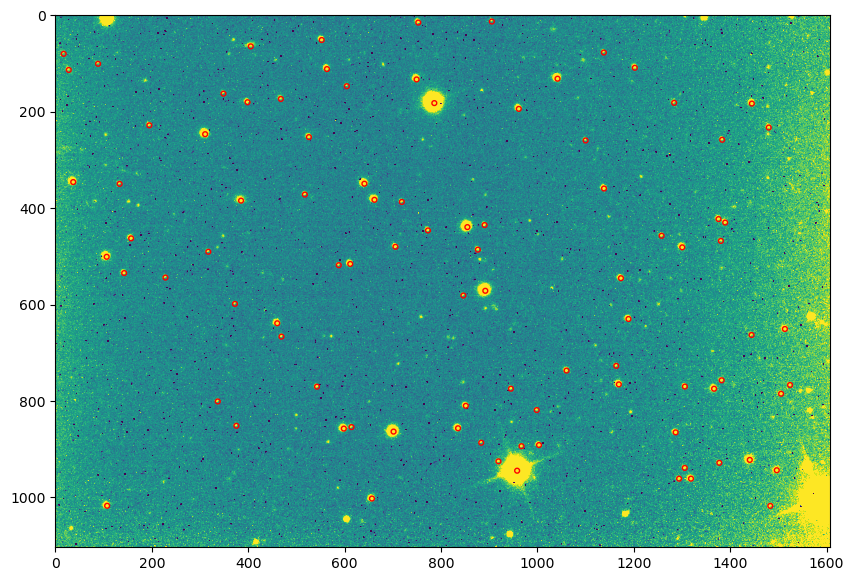

In [307]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(data, vmin=median - 3 * sigma, vmax=median + 3 * sigma)
# plotting circles on top of all detected sources
circles = [
    plt.Circle(
        (source["XWIN_IMAGE"], source["YWIN_IMAGE"]),
        radius=5,
        edgecolor="r",
        facecolor="None",
    )
    for source in cleanSources
]
for c in circles:
    ax.add_artist(c)


plt.show()

In [308]:
psfConfigFile = (
    "C:\\Users\\norna\\OneDrive\\Desktop\\kcap\\config\\photometry.psfex"
)
try:
    command = [
        "psfex",
        "-c", psfConfigFile,
        catalogName
    ]
    print("Executing command: %s" % " ".join(command))
    run_command(command)
except subprocess.CalledProcessError as err:
    print("Could not run psfex with exit error %s" % err)

Executing command: psfex -c C:\Users\norna\OneDrive\Desktop\kcap\config\photometry.psfex C:\Users\norna\OneDrive\Desktop\kcap\data\20251017142-734-RA.wcs.proc.fits.cat
Executing command:
wsl psfex -c /mnt/c/Users/norna/OneDrive/Desktop/kcap/config/photometry.psfex /mnt/c/Users/norna/OneDrive/Desktop/kcap/data/20251017142-734-RA.wcs.proc.fits.cat
Command completed successfully


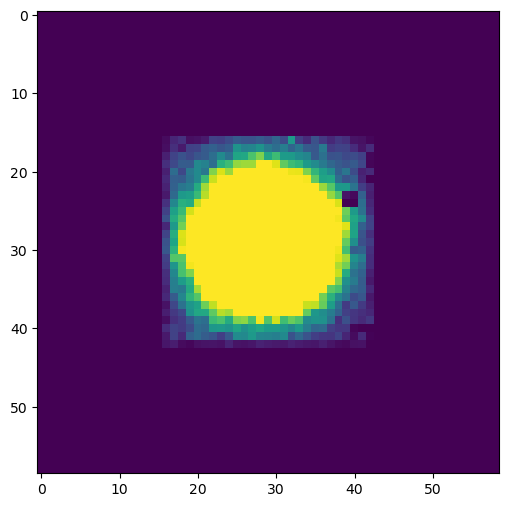

In [309]:
image_psf = imageName + ".psf"
psfModelData = fits.open(image_psf)[1].data[0][0][0]
mean, median, std = sigma_clipped_stats(psfModelData)
plt.figure(figsize=(6, 6))
plt.imshow(psfModelData, vmin=0, vmax=median + 20 * std)
plt.show()

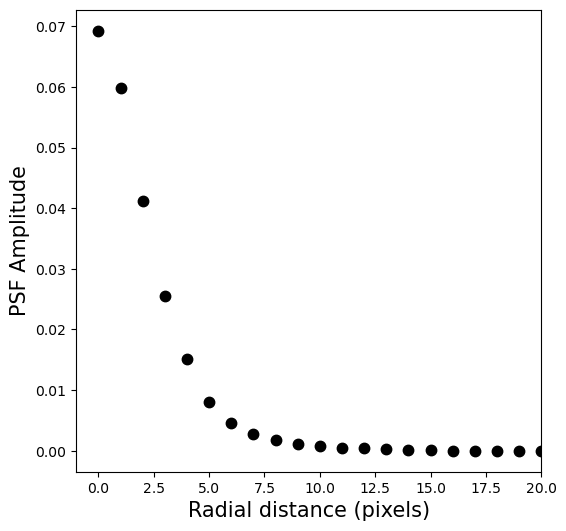

In [310]:
psfImageCenter = [(psfModelData.shape[0] - 1) / 2, (psfModelData.shape[1] - 1) / 2]
y, x = np.indices(psfModelData.shape)
r = np.sqrt((x - psfImageCenter[0]) ** 2 + (y - psfImageCenter[1]) ** 2)
r = r.astype(np.int32)

tbin = np.bincount(r.ravel(), psfModelData.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

plt.figure(figsize=(6, 6))
plt.plot(range(len(radialprofile)), radialprofile, "k.", markersize=15)
plt.xlabel("Radial distance (pixels)", fontsize=15)
plt.ylabel("PSF Amplitude", fontsize=15)
plt.xlim(-1, 20)
plt.show()

In [311]:
psfName = imageName + ".psf"
psfcatalogName = imageName + ".psf.cat"
psfparamName = r"C:\Users\norna\OneDrive\Desktop\kcap\config\sex_PSF.param"

command = [
    "sex",
    "-c", configFile,
    imageName,
    "-CATALOG_NAME", psfcatalogName,
    "-PSF_NAME", psfName,
    "-PARAMETERS_NAME", psfparamName,
]
run_command(command)

Executing command:
wsl sex -c /mnt/c/Users/norna/OneDrive/Desktop/kcap/config/astrom.sex /mnt/c/Users/norna/OneDrive/Desktop/kcap/data/20251017142-734-RA.wcs.proc.fits -CATALOG_NAME /mnt/c/Users/norna/OneDrive/Desktop/kcap/data/20251017142-734-RA.wcs.proc.fits.psf.cat -PSF_NAME /mnt/c/Users/norna/OneDrive/Desktop/kcap/data/20251017142-734-RA.wcs.proc.fits.psf -PARAMETERS_NAME /mnt/c/Users/norna/OneDrive/Desktop/kcap/config/sex_PSF.param
Command completed successfully


In [312]:
psfsourceTable = get_table_from_ldac(psfcatalogName)
# Let's look at the contents of the table
print(psfsourceTable.colnames)
print(psfsourceTable)

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FWHMPSF_IMAGE', 'FWHMPSF_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']
           VIGNET              X_IMAGE   ... FLUXRATIOERR_POINTSOURCE
             ct                  pix     ...                         
---------------------------- ----------- ... ------------------------
      -1e+30 ..     2.732572    108.8075 ...                  0.00000
   -2.365758 ..    -0.546174    752.6528 ...                  0.00000
      -1e+30 ..      2.26782    905.5201 ...                  0.00000
      -1e+30 ..    0.4652557   1347.4313 ...             

In [313]:
# Selecting the clean sources away from image edges as before
cleanPSFSources = psfsourceTable[
    (psfsourceTable["FLAGS"] == 0)
    & (psfsourceTable["FLAGS_MODEL"] == 0)
    & (psfsourceTable["FWHM_WORLD"] > 1 / 3600)
    & (psfsourceTable["FWHM_WORLD"] < 6 / 3600)
    & (psfsourceTable["XWIN_IMAGE"] < (axis1 - 10))
    & (psfsourceTable["XWIN_IMAGE"] > 10)
    & (psfsourceTable["YWIN_IMAGE"] < (axis2 - 10))
    & (psfsourceTable["YWIN_IMAGE"] > 10)
]


In [314]:
# sourceCatCoords = SkyCoord(
#     ra=cleanSources["ALPHAWIN_J2000"],
#     dec=cleanSources["DELTAWIN_J2000"],
#     frame="icrs",
#     unit="degree",
# )
ps1CatCoords = SkyCoord(
    ra=good_cat_stars["RAJ2000"],
    dec=good_cat_stars["DEJ2000"],
    frame="icrs",
    unit="degree",
)

In [ ]:
psfsourceCatCoords = SkyCoord(
    ra=cleanPSFSources["ALPHAWIN_J2000"],
    dec=cleanPSFSources["DELTAWIN_J2000"],
    frame="icrs",
    unit="degree",
)
# Now cross match sources
photoDistThresh = 0.4
idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(
    psfsourceCatCoords, photoDistThresh * u.arcsec
)


print("Found %d good cross-matches" % len(idx_psfimage))
medFWHM = np.median(cleanPSFSources["FWHM_WORLD"][idx_psfimage]) * 3600
print(f"med FWHM of the image is: {medFWHM}")

Found 52 good cross-matches
med FWHM of the image is: 2.347551891580224


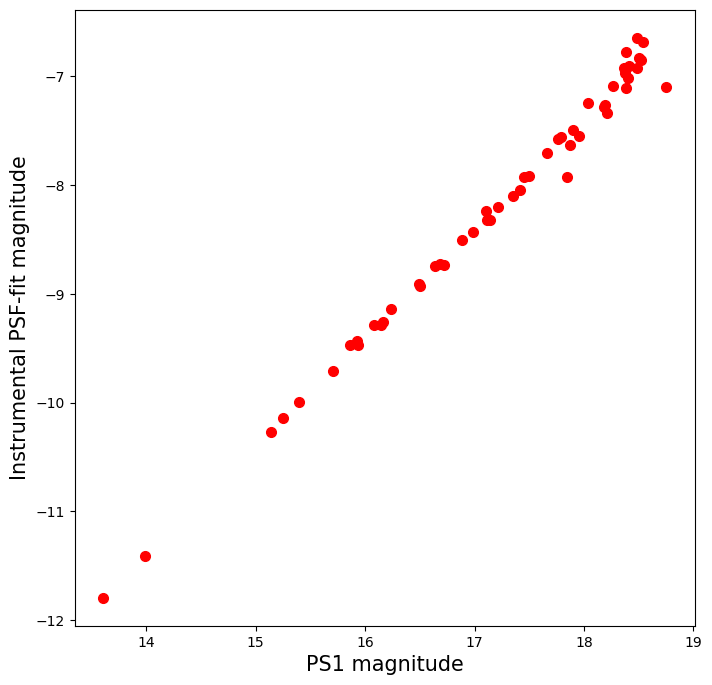

In [316]:
plt.figure(figsize=(8, 8))
# Plotting instrumental magnitude for aperture sizes of 5.0, 6.0 and 7.0 pixels
plt.plot(
    good_cat_stars[f"{filt}mag"][idx_psfps1],
    cleanPSFSources["MAG_POINTSOURCE"][idx_psfimage],
    "r.",
    markersize=14,
)
# plt.ylim(-16, -7.5)
plt.xlabel("PS1 magnitude", fontsize=15)
# plt.axvline(x=19.7, color="k", linestyle="--")
plt.ylabel("Instrumental PSF-fit magnitude", fontsize=15)
plt.show()

In [317]:
psfoffsets = ma.array(
    good_cat_stars[f"{filt}mag"][idx_psfps1]
    - cleanPSFSources["MAG_POINTSOURCE"][idx_psfimage]
)
# Compute sigma clipped statistics
zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
print(
    "PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f"
    % (zero_psfmean, zero_psfmed, zero_psfstd)
)

PSF Mean ZP: 25.40
PSF Median ZP: 25.40
PSF STD ZP: 0.06


In [318]:

 def cal_med_err(data):
     psf_zp_err = zero_psfstd
     inst_magerr = cleanPSFSources["MAGERR_POINTSOURCE"][idx_psfimage]
     psf_mag_err = np.sqrt(inst_magerr**2 + psf_zp_err**2)
     med_error = np.median(psf_mag_err)
     return med_error

In [319]:
 med_err = cal_med_err(data)
print(f"The median PSF magnitude error is: {med_err}")

The median PSF magnitude error is: 0.06905223429203033


In [320]:
from astropy.nddata.utils import Cutout2D


def cal_lim_mag(imageName, ra, dec, psf_ZP, medFWHM, pix_scale):
    # medFWHM is in arcsec, need in pixel
    medFWHM = medFWHM / pix_scale
    f = fits.open(imageName)
    image_data = f[0].data  # This is the image array
    image_header = f[0].header
    wcs = WCS(image_header)
    size = 100
    x, y = wcs.world_to_pixel(SkyCoord(ra * u.deg, dec * u.deg))
    position = [x, y]
    cutout = Cutout2D(image_data, position=position, size=size, wcs=wcs)
    # _, _, sigma_back_ = sigma_clipped_stats(image_data)
    # print("########## image_std", sigma_back_)
    _, _, sigma_back = sigma_clipped_stats(cutout.data)
    # print("########## cutout_std", sigma_back)
    flux_5 = 5 * sigma_back * np.sqrt(np.pi * float(medFWHM) ** 2)
    flux_3 = 3 * sigma_back * np.sqrt(np.pi * float(medFWHM) ** 2)
    mag_5 = -2.5 * np.log10(flux_5) + psf_ZP
    mag_3 = -2.5 * np.log10(flux_3) + psf_ZP
    try:
        lim_mag_5 = mag_5
        lim_mag_3 = mag_3
    except:
        lim_mag_5 = -99
        lim_mag_3 = -99
    return lim_mag_5, lim_mag_3

In [321]:
lim_mag_5, lim_mag_3 = cal_lim_mag(
    imageName, raImage, decImage, zero_psfmed, medFWHM, 0.4
)
print(f"5-sigma limiting magnitude: {lim_mag_5}")
print(f"3-sigma limiting magnitude: {lim_mag_3}")

5-sigma limiting magnitude: 20.32130115087008
3-sigma limiting magnitude: 20.87592302491097
